## Prepocessing

In [70]:
from F4 import PNL_per_day, DumpCSV_and_MesToTele, position_input, position_report, BacktestInformation
import pandas as pd
import datetime
import numpy as np
import time
import requests
from time import sleep
from ta.momentum import RSIIndicator, AwesomeOscillatorIndicator
from ta.trend import MACD, CCIIndicator
from ta.volatility import BollingerBands
from ta.volume import MFIIndicator
import warnings
warnings.filterwarnings('ignore')
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True, connected=True)

In [71]:
data = pd.read_csv('.\data1mins.csv')
data

Loading ITables v2.5.2 from the internet... (need help?)


In [72]:
data.Date = pd.to_datetime(data.Date, errors = 'coerce')
data = data.set_index("Date")
data = data.resample('10Min').agg({'Open': 'first', 'Close': 'last', 'High': 'max', 'Low': 'min', 'Volume': 'sum'}).dropna()
data = data.reset_index()

## Split data into train and practical test

In [73]:
train_size = int(len(data) * 0.8)

In [74]:
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

## Model 

In [75]:
from scipy import signal
from scipy.signal import butter,lfilter 

def lowpass_filter_period_only(x, cutoff_period: int = 20, order: int = 2, zero_phase: bool = False):
    cutoff_period = max(int(cutoff_period), 3)  # kẹp tối thiểu 3
    Wn = 2.0 / float(cutoff_period)
    Wn = min(max(Wn, 1e-6), 0.999999)          # đảm bảo (0,1)
    sos = butter(order, Wn, btype="low", output="sos")
    if zero_phase:
        y = signal.sosfiltfilt(sos, pd.Series(x).values, method="gust")
    else:
        y = signal.sosfilt(sos, pd.Series(x).values)
    return pd.Series(y, index=pd.Series(x).index)


In [76]:
df = pd.read_csv('.\expiration_date.csv')
df.Date = pd.to_datetime(df['Date'])
expiration_date = set(map(lambda x: x.date(), df['Date']))
expiration_date

{datetime.date(2237, 5, 18),
 datetime.date(2124, 1, 20),
 datetime.date(2220, 12, 21),
 datetime.date(2065, 11, 19),
 datetime.date(2088, 5, 20),
 datetime.date(2246, 1, 15),
 datetime.date(2045, 10, 19),
 datetime.date(2249, 10, 18),
 datetime.date(2207, 9, 17),
 datetime.date(2195, 3, 19),
 datetime.date(2180, 3, 16),
 datetime.date(2096, 12, 20),
 datetime.date(2056, 8, 17),
 datetime.date(2085, 7, 19),
 datetime.date(2070, 3, 20),
 datetime.date(2051, 11, 16),
 datetime.date(2117, 8, 19),
 datetime.date(2150, 6, 18),
 datetime.date(2155, 7, 17),
 datetime.date(2202, 4, 15),
 datetime.date(2153, 12, 20),
 datetime.date(2021, 11, 18),
 datetime.date(2099, 2, 19),
 datetime.date(2198, 1, 18),
 datetime.date(2225, 6, 16),
 datetime.date(2115, 8, 15),
 datetime.date(2244, 12, 19),
 datetime.date(2053, 4, 17),
 datetime.date(2033, 10, 20),
 datetime.date(2049, 8, 19),
 datetime.date(2170, 9, 20),
 datetime.date(2203, 5, 19),
 datetime.date(2119, 11, 16),
 datetime.date(2227, 2, 15),
 da

In [77]:
import datetime
import pandas as pd
from ta.trend import MACD

def alpha(data, params, expiration_date=set()):
    """
    CHỈ MACD:
      - Entry LONG : MACD line cắt LÊN signal; (tuỳ chọn) lọc zero-line: MACD > 0
      - Entry SHORT: MACD line cắt XUỐNG signal; (tuỳ chọn) lọc zero-line: MACD < 0
      - Exit LONG  : MACD cắt XUỐNG signal; (tuỳ chọn) thoát khi histogram < 0
      - Exit SHORT : MACD cắt LÊN signal;   (tuỳ chọn) thoát khi histogram > 0

    Ghi chú:
      - zero_filter:  yêu cầu cùng phía zero-line khi vào lệnh (giảm whipsaw).
      - exit_on_zero: dùng histogram vượt 0 như 1 điều kiện phụ để thoát.
      - Giữ các luật time-based: 14:25 đóng short, 14:45 reset nếu ngày đáo hạn.
    """
    df = data.copy()

    df['Close_filtered'] =  lowpass_filter_period_only(data['Close'], params['t1'])
    
    macd_ind = MACD(
        close=df['Close_filtered'],
        window_fast=params.get('macd_fast', 12),
        window_slow=params.get('macd_slow', 26),
        window_sign=params.get('macd_signal', 9)
    )
    df['MACD_LINE']   = macd_ind.macd()
    df['MACD_SIGNAL'] = macd_ind.macd_signal()
    df['MACD_HIST']   = macd_ind.macd_diff()

    macd = df['MACD_LINE']
    sig  = df['MACD_SIGNAL']
    hist = df['MACD_HIST']

    # Giao cắt MACD line với signal
    cross_up   = (macd.shift(1) <= sig.shift(1)) & (macd > sig)     # bullish crossover
    cross_down = (macd.shift(1) >= sig.shift(1)) & (macd < sig)     # bearish crossover

    zero_filter = bool(params.get('zero_filter', True))   # mặc định bật
    exit_on_zero = bool(params.get('exit_on_zero', True)) # mặc định bật

    pos = 0
    position = []

    for i in range(len(df)):
        # Bỏ qua khi chưa đủ dữ liệu
        if pd.isna(macd.iat[i]) or pd.isna(sig.iat[i]):
            position.append(pos)
            continue

        # ===== ENTRY =====
        if pos == 0:
            if cross_up.iat[i]:
                if (not zero_filter) or (macd.iat[i] > 0):
                    pos = 1
            elif cross_down.iat[i]:
                if (not zero_filter) or (macd.iat[i] < 0):
                    pos = -1

        # ===== EXIT =====
        elif pos == 1:  # đang Long
            exit_cond = cross_down.iat[i]
            if exit_on_zero and not pd.isna(hist.iat[i]):
                exit_cond = exit_cond or (hist.iat[i] < 0)
            if exit_cond:
                pos = 0

        elif pos == -1:  # đang Short
            exit_cond = cross_up.iat[i]
            if exit_on_zero and not pd.isna(hist.iat[i]):
                exit_cond = exit_cond or (hist.iat[i] > 0)
            if exit_cond:
                pos = 0

        # ===== TIME-BASED RULES =====
        dt_i = pd.to_datetime(df['Date'].iat[i])
        if dt_i.time() == datetime.time(14, 25):
            if pos == -1:
                pos = 0
        if dt_i.time() == datetime.time(14, 45):
            if len(position) > 0 and (dt_i.date() in expiration_date):
                pos = 0

        position.append(pos)

    df['pos'] = position
    return df


## Tuning parameters

In [78]:
# # pip install optuna ta pandas numpy
# import optuna
# import numpy as np
# import pandas as pd

# # ==== Metric & backtest (gọn, không lookahead) ====
# def compute_metrics(df, price_col='Close', pos_col='pos',
#                     slip_bps=1.0, fee_bps=1.0):
#     """
#     - slip_bps, fee_bps: chi phí mỗi lần đổi vị thế (basis points, 1 bps = 0.01%)
#     - Trả về Sharpe (annualized ~252 ngày), MDD, #trades
#     """
#     df = df.copy()

#     # Lợi nhuận theo % mỗi bar
#     ret = df[price_col].pct_change().fillna(0.0)
#     pos = df[pos_col].fillna(0.0)

#     # Khớp lệnh bar sau để tránh lookahead trong P&L
#     pos_shift = pos.shift(1).fillna(0.0)
#     strat_ret = ret * pos_shift

#     # Phí/ trượt giá khi thay đổi vị thế (đơn giản: khi |Δpos| > 0)
#     delta_pos = pos.diff().abs().fillna(0.0)
#     trade_cost = (slip_bps + fee_bps) / 10000.0
#     cost = delta_pos * trade_cost
#     # Trừ chi phí vào lợi nhuận
#     strat_ret = strat_ret - cost

#     # Gộp theo ngày để tính Sharpe ngày
#     if 'Date' in df.columns:
#         day = pd.to_datetime(df['Date']).dt.date
#         daily_ret = strat_ret.groupby(day).sum()
#     else:
#         daily_ret = strat_ret

#     mean = daily_ret.mean()
#     std  = daily_ret.std(ddof=1)
#     sharpe = 0.0 if std == 0 else (mean / std) * np.sqrt(252)

#     # MDD
#     eq = (1 + daily_ret).cumprod()
#     dd = (eq.cummax() - eq) / eq.cummax()
#     mdd = dd.max() if len(dd) else 0.0

#     # Số lần đổi vị thế (đếm “giao dịch”)
#     trades = int((delta_pos > 0).sum())

#     return {'sharpe': float(sharpe), 'mdd': float(mdd), 'trades': trades}

# # === Optuna objective chỉ tối ưu MACD ===
# import optuna

# def make_objective_macd(data, expiration_dates=None, base_params=None):
#     """
#     - data: DataFrame có cột ['Date','Open','High','Low','Close','Volume', ...]
#     - alpha: dùng bản 'chỉ MACD' đã định nghĩa trước đó:
#         alpha(data, params, expiration_date=set())
#     - base_params: có thể truyền mặc định; hàm sẽ cập nhật bằng trial params
#     """
#     base_params = dict(base_params or {})

#     def objective(trial: optuna.Trial):
#         # ---- Search space (có ràng buộc fast < slow) ----
#         macd_fast   = trial.suggest_int('macd_fast', 0, 30)
#         macd_slow   = trial.suggest_int('macd_slow', 15, 50)  # phụ thuộc fast
#         macd_signal = trial.suggest_int('macd_signal', 0, 20)

#         zero_filter  = trial.suggest_categorical('zero_filter', [True, False])
#         exit_on_zero = trial.suggest_categorical('exit_on_zero', [True, False])

#         # ---- Lắp params cho alpha ----
#         params = {
#             'macd_fast':   macd_fast,
#             'macd_slow':   macd_slow,
#             'macd_signal': macd_signal,
#             'zero_filter': zero_filter,
#             'exit_on_zero': exit_on_zero,
#         }
#         params.update(base_params)  # nếu base có key khác (không đụng MACD) thì giữ

#         # ---- Chạy chiến lược ----
#         df_pos = alpha(data, params, expiration_date=set(expiration_dates or []))

#         # ---- Tính metric ----
#         metrics = compute_metrics(df_pos, slip_bps=1.0, fee_bps=1.0)
#         score = metrics['sharpe']

#         # (tuỳ chọn) phạt nếu quá ít giao dịch
#         if metrics['trades'] < 5:
#             score -= 0.5
#         # (tuỳ chọn) kết hợp rủi ro
#         # score -= 0.5 * metrics['mdd']

#         trial.report(score, step=0)
#         return score

#     return objective

# sampler = optuna.samplers.TPESampler(seed=42, multivariate=True, group=True)
# pruner  = optuna.pruners.MedianPruner(n_warmup_steps=10)

# study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)

# # (tuỳ chọn) mặc định khác ngoài MACD — sẽ không ghi đè các tham số MACD do trial chọn
# base_params = {
#     'macd_fast': 18,
#     'macd_slow': 29,
#     'macd_signal': 18,
#     'zero_filter': True,   # yêu cầu MACD cùng phía zero-line khi vào lệnh
#     'exit_on_zero': True,  # dùng histogram vượt 0 để phụ thoát vị thế
# }


# study.optimize(make_objective_macd(data, expiration_dates=None, base_params=base_params),
#                n_trials=200, show_progress_bar=True)

# print("Best Sharpe:", study.best_value)
# print("Best params:", study.best_params)

# # Backtest với bộ tốt nhất
# best_params = base_params.copy()
# best_params.update(study.best_params)
# df_best = alpha(data, best_params)
# final = compute_metrics(df_best, slip_bps=1.0, fee_bps=1.0)
# print("Final metrics:", final)


In [79]:
params = {
    't1': 0.75,
    'macd_fast': 18,
    'macd_slow': 29,
    'macd_signal': 18,
    'zero_filter': True,   # yêu cầu MACD cùng phía zero-line khi vào lệnh
    'exit_on_zero': True,  # dùng histogram vượt 0 để phụ thoát vị thế
}


In [80]:
ds = alpha(data, params)
ds

Loading ITables v2.5.2 from the internet... (need help?)


Margin: 7.99
MDD: 140.7 (9.1%)

   Total trading quantity: 750
         Profit per trade: 1.36
             Total Profit: 1333.3
         Profit after fee: 1019.3
 Trading quantity per day: 0.4
 Profit per day after fee: 0.54
                   Return: 0.09
          Profit per year: 133.78
                  HitRate: 0.41
          HitRate per day: 0.24


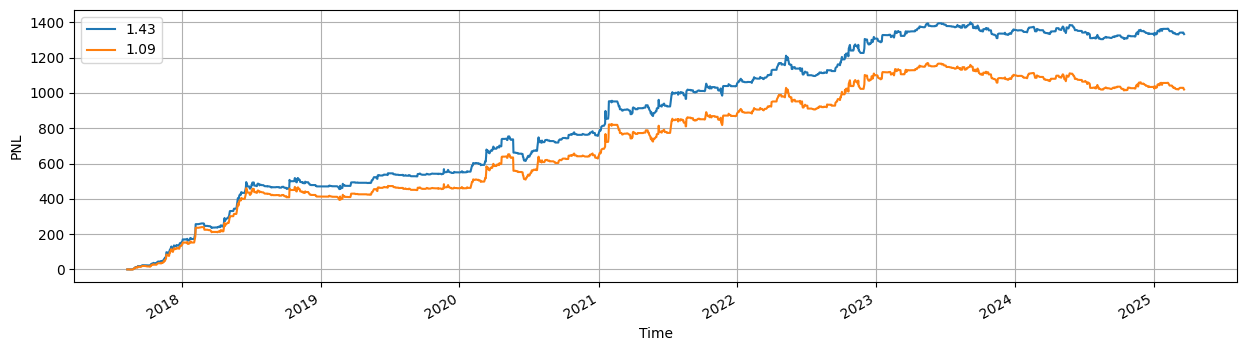

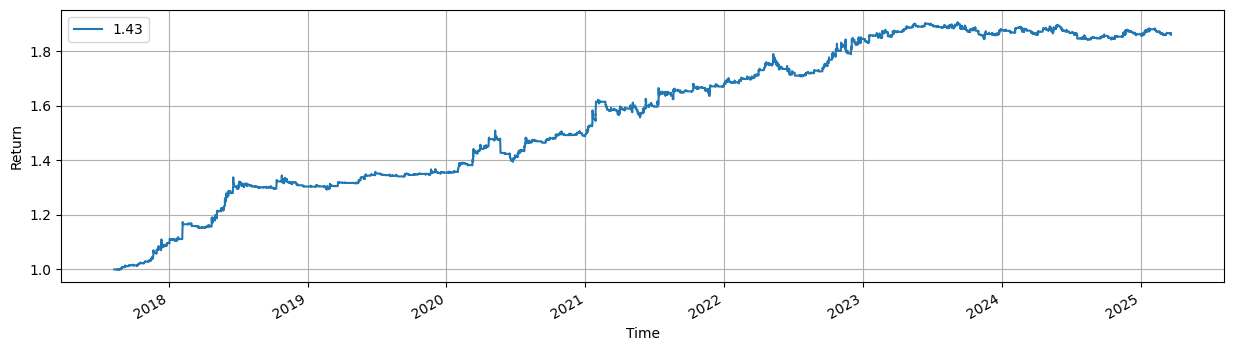

In [81]:
backtestInfo = BacktestInformation(ds['Date'], ds['pos'], ds['Close'], fee = 0.3) 
pnl = backtestInfo.Plot_PNL()

In [82]:
ds.pos

Loading ITables v2.5.2 from the internet... (need help?)


In [83]:
pnl

Loading ITables v2.5.2 from the internet... (need help?)
